# Preparação do ambiente Spark

In [1]:
!pip -qq install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder\
    .master('local[*]')\
    .appName("NLP com Spark")\
    .getOrCreate()

# Importação dos dados

A base de dados do projeto é composta por reviews sobre filmes postadas no site IMBD

In [4]:
!mkdir assets
! wget -qq -O ./assets/imdb-reviews.zip https://github.com/kamillafsilva/nlp_imdb_review/blob/main/imdb-reviews.zip?raw=true

In [5]:
!unzip -qq ./assets/imdb-reviews.zip  -d ./assets/

In [6]:
raw = spark.read.parquet('./assets/imdb-reviews')

Temos duas colunas de reviews: a original em inglês (`text_en`) e a versão traduzida para o português (`text_pt`). A coluna `sentiment` traz a classificação do tipo de review em positiva ou negativa

In [7]:
raw.show(5)

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
+---+--------------------+--------------------+---------+
only showing top 5 rows



In [8]:
raw.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [9]:
raw.count()

49459

# Explorando os dados

## Dados faltantes

In [10]:
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql import functions as f

In [11]:
cat = [f.name for f in raw.schema.fields if isinstance(f.dataType, StringType)] #campos categóricos

In [12]:
raw\
  .select([f.count(f.when(f.isnull(c) | (f.col(c) == ''), 1)).alias(c) for c in cat])\
  .show()

+-------+-------+---------+
|text_en|text_pt|sentiment|
+-------+-------+---------+
|      0|      0|        0|
+-------+-------+---------+



In [ ]:
raw \
  .select('sentiment')\
  .groupBy('sentiment')\
  .count()\
  .show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



## Limpeza dos dados

Nessa etapa faremos a remosão de:

*   Caracteres especias
*   Espaços antes e depois das frases
* Stop Words (preposições, pronomes, verbos, etc..)




In [13]:
import string

In [14]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
raw = raw\
  .withColumn('text_en_regex', f.regexp_replace('text_en', "[\$#,\"!%&'()*+-./:;<=>?@^_´{|}~\\\\]", ''))\
  .withColumn('text_pt_regex', f.regexp_replace('text_pt', "[\$#,\"!%&'()*+-./:;<=>?@^_´{|}~\\\\]", ''))

In [16]:
raw = raw\
  .withColumn('text_en_trim', f.trim(raw.text_en_regex))\
  .withColumn('text_pt_trim', f.trim(raw.text_pt_regex))

In [17]:
raw.show(5)

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|       text_en_regex|       text_pt_regex|        text_en_trim|        text_pt_trim|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Mais uma vez o Sr...|Once again Mr Cos...|Mais uma vez o Sr...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|Este é um exemplo...|This is an exampl...|Este é um exemplo...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|Primeiro de tudo ...|First of all I ha...|Primeiro de tudo ...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Nem mesmo os Beat...|Not even the Beat...|Nem mesmo os Beat...|
|  5|B

Visualizando as palavras mais frequêntes nas reviews com uma nuvem de palavras

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [19]:
review_sample = raw.select('text_pt').sample(fraction = 0.1, seed = 42)
all_text = [text['text_pt'] for text in review_sample.collect()]

In [20]:
wordcloud = WordCloud(background_color='white',
                      width=1000,
                      height=600,
                      collocations=False,
                      prefer_horizontal = 1
                      ).generate(str(all_text))

Várias das palavras mais frequentes entram na categoria de *stop words*
 (preposições, pronomes, verbos, etc..)

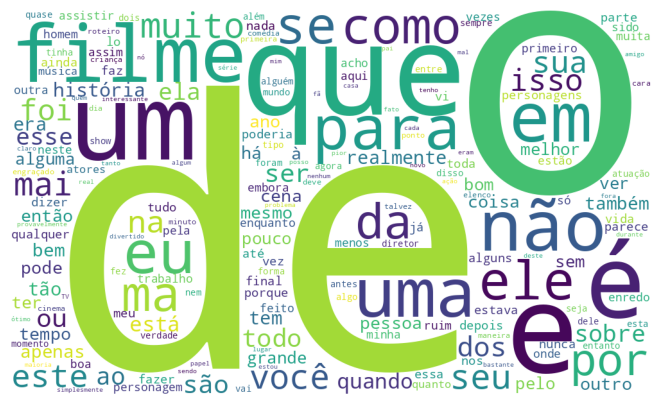

In [21]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Para remover as *stop words* precisamos primeiro tokenizar os dados. O processo de tokenização transforma cada review em uma lista de palavras

In [22]:
from pyspark.ml.feature import Tokenizer

In [23]:
tokenizer_en = Tokenizer(inputCol="text_en_trim", outputCol="tokens_en")
tokenizer_pt = Tokenizer(inputCol="text_pt_trim", outputCol="tokens_pt")
raw_tokenized = tokenizer_en.transform(raw)
raw_tokenized = tokenizer_pt.transform(raw_tokenized)

In [24]:
raw_tokenized.select('text_pt_trim', 'tokens_pt').show(5)

+--------------------+--------------------+
|        text_pt_trim|           tokens_pt|
+--------------------+--------------------+
|Mais uma vez o Sr...|[mais, uma, vez, ...|
|Este é um exemplo...|[este, é, um, exe...|
|Primeiro de tudo ...|[primeiro, de, tu...|
|Nem mesmo os Beat...|[nem, mesmo, os, ...|
|Filmes de fotos d...|[filmes, de, foto...|
+--------------------+--------------------+
only showing top 5 rows



In [25]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from pyspark.ml.feature import StopWordsRemover

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
stop_en = stopwords.words('english')
stop_pt = stopwords.words('portuguese')

In [27]:
remover_en = StopWordsRemover(inputCol='tokens_en', outputCol='clean_en', stopWords=stop_en)
remover_pt = StopWordsRemover(inputCol='tokens_pt', outputCol='clean_pt', stopWords=stop_pt)

raw_clean = remover_en.transform(raw_tokenized)
raw_clean = remover_pt.transform(raw_clean)

In [28]:
raw_clean.select('text_en', 'clean_en', 'text_pt', 'clean_pt').show(5)

+--------------------+--------------------+--------------------+--------------------+
|             text_en|            clean_en|             text_pt|            clean_pt|
+--------------------+--------------------+--------------------+--------------------+
|Once again Mr. Co...|[mr, costner, dra...|Mais uma vez, o S...|[vez, sr, costner...|
|This is an exampl...|[example, majorit...|Este é um exemplo...|[exemplo, motivo,...|
|First of all I ha...|[first, hate, mor...|Primeiro de tudo ...|[primeiro, tudo, ...|
|Not even the Beat...|[even, beatles, c...|Nem mesmo os Beat...|[beatles, puderam...|
|Brass pictures mo...|[brass, pictures,...|Filmes de fotos d...|[filmes, fotos, l...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [29]:
review_sample = raw_clean.select('clean_pt').sample(fraction = 0.1, seed = 42)
all_text = [word for token in review_sample.collect() for word in token['clean_pt']]

In [30]:
wordcloud_clean = WordCloud(background_color='white',
                      width=1000,
                      height=600,
                      collocations=False,
                      prefer_horizontal = 1
                      ).generate(str(all_text))

A nova nuvem de palavras após a remoção

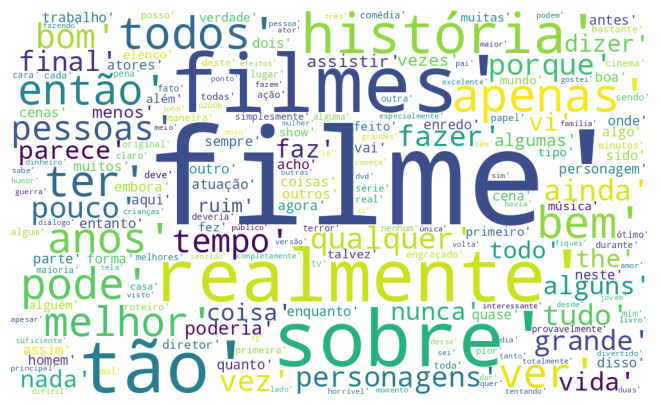

In [31]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_clean)
plt.axis('off')
plt.show()

# Construção do modelo

## Vetorização dos dados

In [41]:
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF

In [37]:
htf = HashingTF(inputCol = 'clean_pt', outputCol='vectors_pt', numFeatures=1000)
hashed = htf.transform(raw_clean)

In [38]:
hashed.select('clean_pt', 'vectors_pt').show(5)

+--------------------+--------------------+
|            clean_pt|          vectors_pt|
+--------------------+--------------------+
|[vez, sr, costner...|(1000,[14,16,22,3...|
|[exemplo, motivo,...|(1000,[10,17,24,3...|
|[primeiro, tudo, ...|(1000,[5,8,37,45,...|
|[beatles, puderam...|(1000,[24,32,37,3...|
|[filmes, fotos, l...|(1000,[12,28,37,4...|
+--------------------+--------------------+
only showing top 5 rows



In [42]:
idf = IDF(inputCol='vectors_pt', outputCol='features')
idf_fitted = idf.fit(hashed)

In [43]:
hashed_idf = idf_fitted.transform(hashed)

In [44]:
hashed_idf.select('vectors_pt', 'features').show(5)

+--------------------+--------------------+
|          vectors_pt|            features|
+--------------------+--------------------+
|(1000,[14,16,22,3...|(1000,[14,16,22,3...|
|(1000,[10,17,24,3...|(1000,[10,17,24,3...|
|(1000,[5,8,37,45,...|(1000,[5,8,37,45,...|
|(1000,[24,32,37,3...|(1000,[24,32,37,3...|
|(1000,[12,28,37,4...|(1000,[12,28,37,4...|
+--------------------+--------------------+
only showing top 5 rows



## Pipeline de processamento

In [45]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

In [46]:
raw_pt = raw.select('id', 'text_pt_trim', 'sentiment')

In [47]:
indexer = StringIndexer(inputCol = 'sentiment', outputCol = 'label')

In [48]:
pipeline = Pipeline(stages = [indexer, tokenizer_pt , remover_pt, htf, idf])
pipeline_fitted = pipeline.fit(raw_pt)

In [49]:
transformed = pipeline_fitted.transform(raw_pt).select('id', 'features', 'label')

In [50]:
transformed.show(5)

+---+--------------------+-----+
| id|            features|label|
+---+--------------------+-----+
|  1|(1000,[14,16,22,3...|  0.0|
|  2|(1000,[10,17,24,3...|  0.0|
|  3|(1000,[5,8,37,45,...|  0.0|
|  4|(1000,[24,32,37,3...|  0.0|
|  5|(1000,[12,28,37,4...|  0.0|
+---+--------------------+-----+
only showing top 5 rows



## Treinando modelos de Classificação

In [51]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

In [52]:
def getConfusionMatrix(model, data):
  label = model.getLabelCol()
  preds = model.transform(data)
  preds_and_labels =preds.select(['prediction',label]).withColumn('label', f.col(label).cast(FloatType())).orderBy('prediction')
  preds_and_labels = preds_and_labels.select(['prediction', 'label'])
  metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
  return metrics.confusionMatrix().toArray()

In [53]:
treino, teste = transformed.randomSplit([0.7, 0.3], seed = 42)

## Regressão Logística

In [54]:
from pyspark.ml.classification import LogisticRegression

In [55]:
logReg = LogisticRegression(featuresCol = 'features', labelCol='label')
logReg_fitted = logReg.fit(treino)

## Árvore de Decisão

In [56]:
from pyspark.ml.classification import DecisionTreeClassifier

In [57]:
tree = DecisionTreeClassifier(featuresCol = 'features', labelCol='label', seed = 42, minInstancesPerNode=5)
tree_fitted = tree.fit(treino)

## XGBoost

In [58]:
from xgboost.spark import SparkXGBClassifier

In [59]:
xgb_params = {'max_depth': 6, 'min_child_weight': 1, 'gamma': 0}

In [60]:
xgb = SparkXGBClassifier(features_col = 'features', label_col='label', seed = 42, verbosity = 0, **xgb_params)
xgb_fitted = xgb.fit(treino)

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1, 'verbosity': 0, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


## Avaliação dos modelos no conjunto de treino

In [61]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd

In [64]:
def classification_report(model, data):
  label = model.getLabelCol()

  acc_evaluator = MulticlassClassificationEvaluator(labelCol = label, predictionCol="prediction",metricName=  'accuracy')
  f1_evaluator = MulticlassClassificationEvaluator(labelCol = label, predictionCol="prediction",metricName=  'f1')
  prec_evaluator = MulticlassClassificationEvaluator(labelCol = label, predictionCol="prediction",metricName=  'precisionByLabel')
  rec_evaluator = MulticlassClassificationEvaluator(labelCol = label, predictionCol="prediction",metricName=  'recallByLabel')
  auc_roc_evaluator = BinaryClassificationEvaluator(labelCol = label, metricName = 'areaUnderROC')

  preds = model.transform(data)

  return [preds, {'acc':acc_evaluator.evaluate(preds), 'f1':f1_evaluator.evaluate(preds), 'prec':prec_evaluator.evaluate(preds), 'rec':rec_evaluator.evaluate(preds), 'auc_roc':auc_roc_evaluator.evaluate(preds)}]

In [65]:
def roc_crossValidator(estimator, data, params: dict | None = None):
  evaluator = BinaryClassificationEvaluator(labelCol = 'label')

  paramGrid = ParamGridBuilder()

  if params is None:
    for k, v in estimator.extractParamMap().items():
      paramGrid = paramGrid.addGrid(estimator.getParam(k.name), [v])
  else:
    for k,v in params.items():
      paramGrid = paramGrid.addGrid(estimator.getParam(k), [v])

  paramGrid = paramGrid.build()

  cv = CrossValidator(
    estimator = estimator,
    estimatorParamMaps = paramGrid,
    evaluator = evaluator,
    numFolds=5,
    seed=42
  )

  cv_fitted = cv.fit(data)
  roc_auc = cv_fitted.avgMetrics[0]

  return roc_auc

In [66]:
models = [logReg_fitted, tree_fitted, xgb_fitted]
results_treino = []

for model in models:
  model_report = classification_report(model, treino)[1]
  results_treino.append(model_report)

In [67]:
pd.DataFrame(results_treino, ['logReg', 'tree', 'xgb'])

,acc,f1,prec,rec,auc_roc
logReg,0.809112,0.809102,0.813715,0.801875,0.887058
tree,0.650723,0.649526,0.670792,0.592248,0.621560
xgb,0.909891,0.909885,0.916642,0.901829,0.972391


In [68]:
results_teste = []

for model in models:
  model_report = classification_report(model, teste)[1]
  results_teste.append(model_report)

In [69]:
pd.DataFrame(results_teste, ['logReg', 'tree', 'xgb'])

,acc,f1,prec,rec,auc_roc
logReg,0.794282,0.794282,0.797676,0.790972,0.872557
tree,0.640708,0.639548,0.661189,0.583571,0.620075
xgb,0.776923,0.776917,0.782369,0.769961,0.855572


O modelo XGBoost teve um desempenho melhor no treino e no teste, mas a queda de performance no teste foi expressiva. Ao invés de mensurar o desempenho no conjunto treino completo podemos utilizar o método de *cross-validation* para ter uma estimativa com menos viés. A métrica escolhida para comparação foi a área sob a curva ROC

In [70]:
models = [logReg, tree, xgb]
roc_cv = []

for model in models:
  if isinstance(model, SparkXGBClassifier):
    model_roc = roc_crossValidator(model, treino, xgb_params)
  else:
     model_roc = roc_crossValidator(model, treino)
  roc_cv.append(model_roc)

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'device': 'cpu', 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1, 'objective': 'binary:logistic', 'verbosity': 0, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'device': 'cpu', 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1, 'objective': 'binary:logistic', 'verbosity': 0, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'device': 'cpu', 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1, 'objective': 'binary:logistic', 'verbosity': 0, 'seed': 42, 'nthread': 

Utilizando esse método vemos que o desempenho do XGBoost ficou abaixo do model Logístico. Isso indica *overfitting* do XGBoost.

In [72]:
pd.DataFrame(roc_cv, ['logReg', 'tree', 'xgb'], ['auc_roc'])

,auc_roc
logReg,0.865423
tree,0.624641
xgb,0.846027


In [81]:
pred_teste = logReg_fitted.transform(teste)

In [74]:
pred_teste.show(5)

+---+--------------------+-----+--------------------+--------------------+----------+
| id|            features|label|       rawPrediction|         probability|prediction|
+---+--------------------+-----+--------------------+--------------------+----------+
|  3|(1000,[5,8,37,45,...|  0.0|[2.38911944397882...|[0.91599383489873...|       0.0|
|  7|(1000,[2,3,7,10,6...|  0.0|[-2.0492380072840...|[0.11412939905008...|       1.0|
|  9|(1000,[0,35,64,66...|  0.0|[1.55042685639817...|[0.82497537461068...|       0.0|
| 10|(1000,[10,19,41,6...|  0.0|[-1.1001389292445...|[0.24971386415414...|       1.0|
| 14|(1000,[29,50,83,1...|  0.0|[1.46082956699593...|[0.81165952210580...|       0.0|
+---+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [84]:
comp_teste = pred_teste\
  .join(raw, 'id', how = 'inner')\
  .select('id', 'text_pt', 'sentiment', 'prediction')

Reviews postivas classificadas corretamente pelo modelo

In [86]:
comp_teste\
  .where('sentiment = "pos" and prediction = 1')\
  .show(5, truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Reviews postivas classificadas como negativas pelo modelo

In [87]:
comp_teste\
  .where('sentiment = "pos" and prediction = 0')\
  .show(5, truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------